In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import pandas as pd
import os
from glob import glob
from paulinggrl2022.twolyr import TwoLayerModel
from paulinggrl2022.cesm_functions import fixmonth
from scipy.stats import linregress
from scipy.integrate import odeint
import cftime
import warnings

warnings.filterwarnings("ignore", category=xr.SerializationWarning)

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 10

In [2]:
experiments = ["piControl", "abrupt-4xCO2"]

variables = ["rtmt", "tas", "rsdt", "rsut"]

models = ["ACCESS-ESM1-5",
          "CanESM5",
          "CESM2",
          "CNRM-CM6-1",
          "EC-Earth3",
          "GISS-E2-1-G",
          "GISS-E2-1-H",
          "INM-CM5-0",
          "IPSL-CM6A-LR",
          "MIROC6",
          "MIROC-ES2L",
          "MPI-ESM1-2-LR",
          "MPI-ESM1-2-HR",
          "MRI-ESM2-0",
          "NorCPM1",
          "UKESM1-0-LL"]

tmpmodels = [
    "MPI-ESM1-2-LR", 
    "MPI-ESM1-2-HR", 
    "CNRM-CM6-1", 
    "MRI-ESM2-0", 
    "EC-Earth3"
]

tmpvariables = ["rsdt", "rsut", "rlut", "tas"]

In [3]:
def globmean(da):
    return da.weighted(np.cos(np.deg2rad(da.lat))).mean(("lat", "lon"))

In [4]:
ddir = "/glade/scratch/apauling/cmip6_downloads/cmip6_downloader/data"
ddict = {}
tmpdict = {}

yrs = np.arange(150)

for name in models:
    print(f"Model = {name}")
    ddict[name] = {}
    tmpdict[name] = {}
    for exp in experiments:
        print(f"  Experiment: {exp}")
        ddict[name][exp] = {}
        tmpdict[name][exp] = {}
        if name in tmpmodels:
            for var in tmpvariables:                
                dpath = "v_"+var+"_f_mon_e_"+exp+"_s_"+name+"/processed"
                dfiles = sorted(glob(os.path.join(ddir, dpath, "*.nc")))
                ens = [d.split("/")[-1].split("_")[4] for d in [dfiles[0]]]

                ds = xr.open_mfdataset(
                    [dfiles[0]],
                    combine="nested",
                    concat_dim="ensmem"
                )
                da = ds[var].isel(time=slice(None, 1800))
                da = globmean(da).groupby("time.year").mean("time").compute()
                da = da.assign_coords({"year": ("year", yrs),
                                       "ensmem": ("ensmem", ens)})
                tmpdict[name][exp][var] = da
        else:
            for var in variables:
                dpath = "v_"+var+"_f_mon_e_"+exp+"_s_"+name+"/processed"
                dfiles = sorted(glob(os.path.join(ddir, dpath, "*.nc")))
                ens = [d.split("/")[-1].split("_")[4] for d in [dfiles[0]]]

                ds = xr.open_mfdataset(
                    [dfiles[0]], 
                    combine="nested",
                    concat_dim="ensmem"
                )
                da = ds[var].isel(time=slice(None, 1800))
                da = globmean(da).groupby("time.year").mean("time").compute()
                da = da.assign_coords({"year": ("year", yrs),
                                       "ensmem": ("ensmem", ens)})
                ddict[name][exp][var] = da

Model = ACCESS-ESM1-5
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = CanESM5
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = CESM2
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = CNRM-CM6-1
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = EC-Earth3
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = GISS-E2-1-G
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = GISS-E2-1-H
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = INM-CM5-0
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = IPSL-CM6A-LR
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = MIROC6
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = MIROC-ES2L
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = MPI-ESM1-2-LR
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = MPI-ESM1-2-HR
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = MRI-ESM2-0
  Experiment: piControl
  Experiment: abrupt-4xCO2
Model = NorCPM1
  Exp

### Fix weird ensemble member naming inconsistency for EC-Earth3

The abrupt-4xCO2 says it is r8i1p1f1 but it is branched from r1i1p1f1

In [5]:
for var in tmpvariables:
    tmpdict["EC-Earth3"]["abrupt-4xCO2"][var] = \
        tmpdict["EC-Earth3"]["abrupt-4xCO2"][var].assign_coords({"ensmem": ("ensmem", ["r1i1p1f1"])})

### Compute net TOA for models that don't have rtmt

In [6]:
for name in tmpmodels:
    for exp in experiments:
        ddict[name][exp]["rtmt"] = tmpdict[name][exp]["rsdt"] - \
            tmpdict[name][exp]["rsut"] - tmpdict[name][exp]["rlut"]

        ddict[name][exp]["tas"] = tmpdict[name][exp]["tas"]
        ddict[name][exp]["rsdt"] = tmpdict[name][exp]["rsdt"]
        ddict[name][exp]["rsut"] = tmpdict[name][exp]["rsut"]

### Load forcing from Schmidt et al. (2018)

In [7]:
ddir = "../../data/forcingdata"
ncsw_c = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.69.nonudge_novolc_icefix.cam.h0.FSNT.198501-200412.nc")
nclw_c = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.69.nonudge_novolc_icefix.cam.h0.FLNT.198501-200412.nc")

ncsw_v = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.70.nonudge_volc_icefix.cam.h0.FSNT.198501-200412.nc")
nclw_v = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.70.nonudge_volc_icefix.cam.h0.FLNT.198501-200412.nc")

dssw_c = xr.open_dataset(ncsw_c)
dslw_c = xr.open_dataset(nclw_c)

dssw_v = xr.open_dataset(ncsw_v)
dslw_v = xr.open_dataset(nclw_v)

time = dssw_c.time.data
timetmp = [pd.to_datetime(t) for t in time]
timenew = [cftime.DatetimeNoLeap(t.year, t.month, t.day) for t in timetmp]

dssw_c = fixmonth(dssw_c.assign_coords({"time": ("time", timenew)}))
dslw_c = fixmonth(dslw_c.assign_coords({"time": ("time", timenew)}))

dssw_v = fixmonth(dssw_v.assign_coords({"time": ("time", timenew)}))
dslw_v = fixmonth(dslw_v.assign_coords({"time": ("time", timenew)}))

toa_c = dssw_c["FSNT"] - dslw_c["FLNT"]
toa_v = dssw_v["FSNT"] - dslw_v["FLNT"]

F_sw = globmean(dssw_v["FSNT"] - dssw_c["FSNT"])
F_lw = -globmean(dslw_v["FLNT"] - dslw_c["FLNT"])
F = F_sw + F_lw

### Plot forcing

Text(0, 0.5, 'forcing [W m$^{-2}$]')

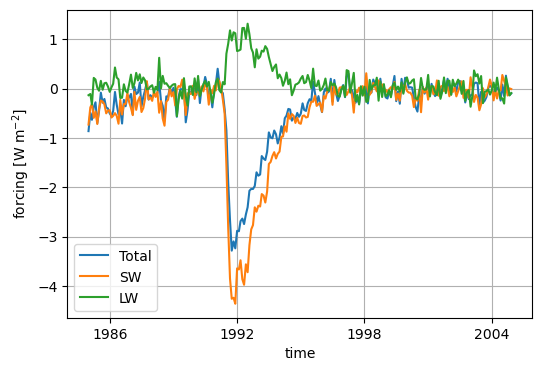

In [8]:
fig = plt.figure(1)
F.plot(label="Total")
F_sw.plot(label="SW")
F_lw.plot(label="LW")

plt.legend()
plt.grid()
plt.ylabel("forcing [W m$^{-2}$]")

### Fit model using 4xCO2 then run using volcanic forcing

In [9]:
tvec_dict = {}
T1_dict = {}
T2_dict = {}
T1_sum = {}  
param_dict = {}
SW_dict = {}
SW_sum = {}
ratio = {}

timevec = pd.date_range("1985-01", "2004-12", freq="MS")

F_sw = F_sw.assign_coords({"time": ("time", timevec)})

for name in models:
    print(f"Model: {name}")
    T = ddict[name]["abrupt-4xCO2"]["tas"] - ddict[name]["piControl"]["tas"]
    N = ddict[name]["abrupt-4xCO2"]["rtmt"] - ddict[name]["piControl"]["rtmt"]
    SW1 = ddict[name]["piControl"]["rsdt"] - ddict[name]["piControl"]["rsut"]
    SW2 = ddict[name]["abrupt-4xCO2"]["rsdt"] - ddict[name]["abrupt-4xCO2"]["rsut"]
    SW = SW2 - SW1
    
    twolayer = TwoLayerModel(model_epsilon="unit")
    
    twolayer.fit_params(T, N)
    twolayer.fit_lambda_sw(T, SW)
    
    param_dict[name] = twolayer.params
    
    T1, T2 = twolayer.solve_model(forcing=F, tstep=1/12)
    
    T1 = T1.interp(time=np.arange(240))
    T2 = T2.interp(time=np.arange(240))
    
    T1_dict[name] = T1.assign_coords({"time": ("time", timevec)})
    T2_dict[name] = T2.assign_coords({"time": ("time", timevec)})
    
    SW_dict[name] = F_sw - param_dict[name]["lam_sw"]*T1_dict[name]
    
    T1_sum[name] = T1_dict[name].sel(time=slice("1991-06", "1996-05")).sum("time")
    SW_sum[name] = SW_dict[name].sel(time=slice("1991-06", "1993-05")).sum("time")
    ratio[name] = -T1_sum[name]/SW_sum[name]
    
    print(twolayer)
    print("") 

Model: ACCESS-ESM1-5
TwoLayerModel
---Parameters---
F: [5.63196135]
lambda: [0.7239345]
T_eq: [7.77965598]
gamma: [0.71214942]
epsilon: [1.]

Model: CanESM5
TwoLayerModel
---Parameters---
F: [7.33406369]
lambda: [0.64927551]
T_eq: [11.29576524]
gamma: [0.52897484]
epsilon: [1.]

Model: CESM2
TwoLayerModel
---Parameters---
F: [6.90138385]
lambda: [0.65527452]
T_eq: [10.53204978]
gamma: [0.72963413]
epsilon: [1.]

Model: CNRM-CM6-1
TwoLayerModel
---Parameters---
F: [7.31939895]
lambda: [0.74947166]
T_eq: [9.76607841]
gamma: [0.50117106]
epsilon: [1.]

Model: EC-Earth3
TwoLayerModel
---Parameters---
F: [6.38943533]
lambda: [0.76060515]
T_eq: [8.40046283]
gamma: [0.7078609]
epsilon: [1.]

Model: GISS-E2-1-G


/glade/u/home/apauling/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


TwoLayerModel
---Parameters---
F: [8.5611019]
lambda: [1.63713018]
T_eq: [5.22933485]
gamma: [0.85730945]
epsilon: [1.]

Model: GISS-E2-1-H
TwoLayerModel
---Parameters---
F: [7.02840819]
lambda: [1.12593064]
T_eq: [6.24231009]
gamma: [0.6435541]
epsilon: [1.]

Model: INM-CM5-0
TwoLayerModel
---Parameters---
F: [5.64062813]
lambda: [1.4701174]
T_eq: [3.83685556]
gamma: [0.63712174]
epsilon: [1.]

Model: IPSL-CM6A-LR
TwoLayerModel
---Parameters---
F: [6.81382232]
lambda: [0.7477323]
T_eq: [9.11264944]
gamma: [0.47728124]
epsilon: [1.]

Model: MIROC6
TwoLayerModel
---Parameters---
F: [7.44801159]
lambda: [1.44257518]
T_eq: [5.16299718]
gamma: [0.68801016]
epsilon: [1.]

Model: MIROC-ES2L
TwoLayerModel
---Parameters---
F: [8.22997877]
lambda: [1.54700921]
T_eq: [5.31992876]
gamma: [0.66765443]
epsilon: [1.]

Model: MPI-ESM1-2-LR
TwoLayerModel
---Parameters---
F: [8.42652415]
lambda: [1.39331241]
T_eq: [6.04783542]
gamma: [0.61598658]
epsilon: [1.]

Model: MPI-ESM1-2-HR
TwoLayerModel
---Par

### Plot two-layer model output

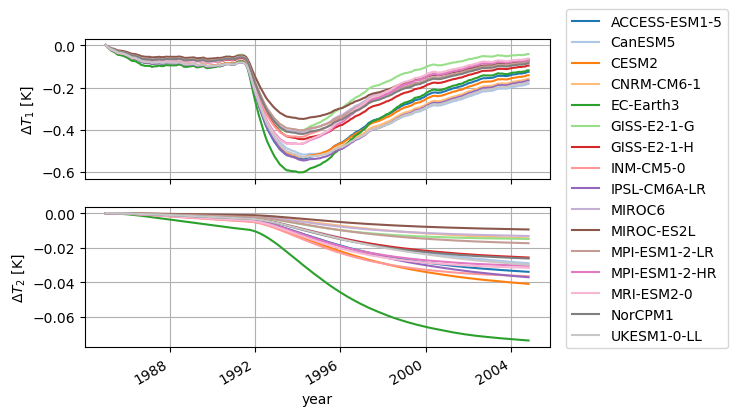

In [10]:
colors = pl.cm.tab20.colors

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for n, name in enumerate(models):
    T1_dict[name].plot.line(
        x="time", 
        label=name, 
        color=colors[n], 
        ax=ax1,
        add_legend=False
    )
    T2_dict[name].plot.line(
        x="time", 
        label=name, 
        color=colors[n], 
        ax=ax2,
        add_legend=False
    )

ax1.legend(loc="center left", bbox_to_anchor=(1.02, 0))

ax1.set_title("")
ax2.set_title("")

ax1.grid()
ax2.grid()

ax1.set_ylabel("$\Delta T_1$ [K]")
ax2.set_ylabel("$\Delta T_2$ [K]")
ax2.set_xlabel("year")
ax1.set_xlabel("")

fig.savefig("../../../figures/volcano/2021/twolyr/twolyr_response.png",
            bbox_inches="tight", dpi=150, facecolor="white")

### Load ECS data from Mark Zelinka GitHub repo

In [11]:
import json

f = open('/glade/work/apauling/cmip56_forcing_feedback_ecs/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test

ACCESS-ESM1-5 = 3.8839034758064876
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
CNRM-CM6-1 = 4.9036506204610255
EC-Earth3 = 4.2600669989023405
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253559
MIROC6 = 2.601790969650521
MIROC-ES2L = 2.6605264351565174
MPI-ESM1-2-LR = 3.0254401947450527
MPI-ESM1-2-HR = 2.9797516932086876
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.031725720887037
UKESM1-0-LL = 5.359162439690016


### Compute correlation between ECS and integrated dT

In [12]:
ecs_array = np.array([ecs_dict[name] for name in models])
t1_sum_array = np.array([float(T1_sum[name].data) for name in models])

slope, intcpt, r_value, p_value, std_err = linregress(ecs_array, t1_sum_array)

print(f"Temperature r = {r_value:5.4f}")

import pickle as pkl

out = {"slope": slope,
       "intcpt": intcpt,
       "r_value": r_value,
       "p_value": p_value,
       "std_err": std_err}

with open("integrate_T_twolyr_result.pkl", "wb") as f:
    pkl.dump(out, f)

Temperature r = -0.8026


### Plot correlation

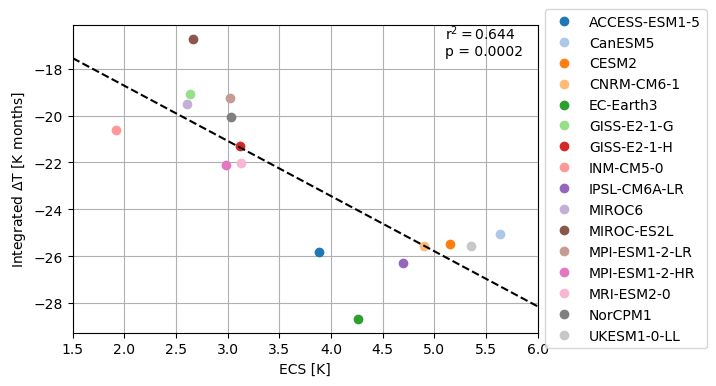

In [13]:
colors = pl.cm.tab20.colors

fig = plt.figure(1)
for n, name in enumerate(models):
    plt.plot(ecs_dict[name], T1_sum[name], "o", color=colors[n], label=name)
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlim(1.5, 6)

x = np.arange(1.5, 6.01, 0.1)
plt.plot(x, slope*x + intcpt, "k--")

plt.annotate(f"r$^2 =${r_value**2:5.3f}\np = {p_value:5.4f}", xy=(0.8, 0.9), xycoords="axes fraction")

plt.ylabel("Integrated $\Delta$T [K months]")
plt.xlabel("ECS [K]")

fig.savefig("../../../figures/volcano/2021/twolyr/twolyr_correlation.png",
            bbox_inches="tight", dpi=150, facecolor="white")

### Combined figure for paper

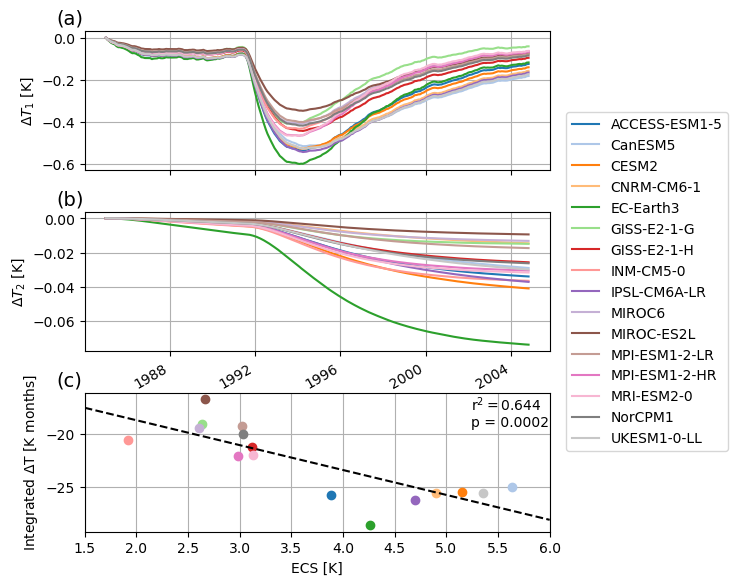

In [14]:
colors = pl.cm.tab20.colors

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6.5))

for n, name in enumerate(models):

    T1_dict[name].plot.line(
        x="time", 
        label=name, 
        color=colors[n],
        ax=ax1,
        add_legend=False
    )
    T2_dict[name].plot.line(
        x="time", 
        label=name, 
        color=colors[n],
        ax=ax2,
        add_legend=False
    )

ax1.set_xticklabels("")
ax1.set_xlabel("")
ax2.set_xlabel("")

ax1.set_title("")
ax2.set_title("")
ax2.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

ax1.grid()
ax2.grid()

ax1.set_ylabel("$\Delta T_1$ [K]")
ax2.set_ylabel("$\Delta T_2$ [K]")

for n, name in enumerate(models):
    ax3.plot(ecs_dict[name], T1_sum[name], "o", color=colors[n], label=name)

ax3.grid()
ax3.set_xlim(1.5, 6)

x = np.arange(1.5, 6.01, 0.1)
ax3.plot(x, slope*x + intcpt, "k--")

ax3.annotate(f"r$^2 =${r_value**2:5.3f}\np = {p_value:5.4f}", xy=(0.83, 0.76), xycoords="axes fraction")

ax3.set_ylabel("Integrated $\Delta$T [K months]")
ax3.set_xlabel("ECS [K]")

fig.subplots_adjust(hspace=0.3)

ax1.annotate("(a)", xy=(-0.06, 1.05), xycoords="axes fraction", fontsize=14)
ax2.annotate("(b)", xy=(-0.06, 1.05), xycoords="axes fraction", fontsize=14)
ax3.annotate("(c)", xy=(-0.06, 1.05), xycoords="axes fraction", fontsize=14)

fig.savefig("../../../figures/volcano/2021/twolyr/twolyr_combined.png",
            bbox_inches="tight", dpi=150)

### Plot SW anomaly from two-layer model

Text(0, 0.5, '$\\Delta$SW [W m$^{-2}$]')

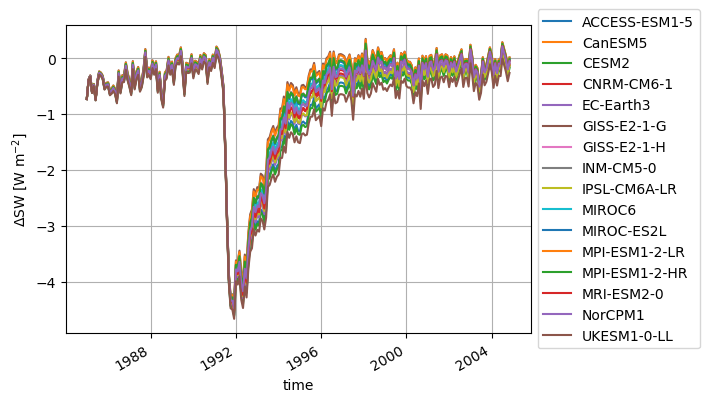

In [15]:
fig = plt.figure(1)
for name in models:    
    SW_dict[name].plot(label=name)
    
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.title("")
plt.grid()
plt.ylabel("$\Delta$SW [W m$^{-2}$]")

### Serialize out two-layer model ratio

In [16]:
import pickle as pkl

with open("twolyr_unitepsilon_ratio.pkl", "wb") as f:
    pkl.dump(ratio, f)

### Compute and plot correlation for integrated ratio

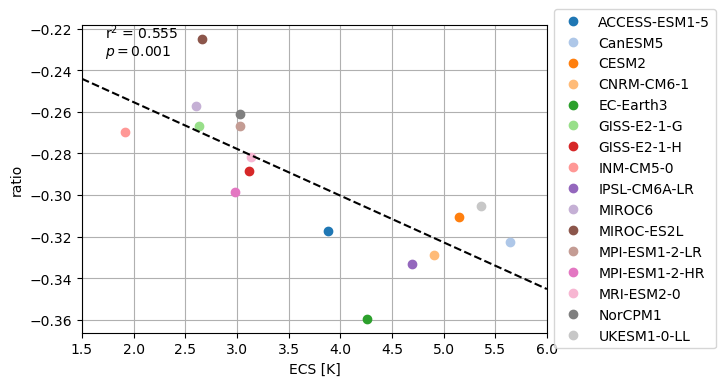

In [17]:
fig = plt.figure(1)

for n, name in enumerate(models):
    plt.plot(ecs_dict[name], ratio[name], 'o', color=colors[n], label=name)
    
ratio_array = np.array([float(ratio[name].data) for name in models])

slope, intcpt, r_value, p_value, std_err = linregress(ecs_array, ratio_array)

y = slope*x + intcpt

plt.plot(x, y, "k--")
plt.xlim(1.5, 6)

plt.annotate(f"r$^2$ = {r_value**2:5.3f}\n$p=${p_value:5.3f}",
             xy=(0.05, 0.9),
             xycoords="axes fraction")

plt.grid()
plt.ylabel("ratio")
plt.xlabel("ECS [K]")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

fig.savefig("../../../figures/volcano/2021/twolyr/twolyr_ratio_corr.png",
            bbox_inches="tight", dpi=150)

out = {"slope": slope,
       "intcpt": intcpt,
       "r_value": r_value,
       "p_value": p_value,
       "std_err": std_err}

with open("integrate_ratio_twolyr_result.pkl", "wb") as f:
    pkl.dump(out, f)

### Compute and plot correlation for integrated SW

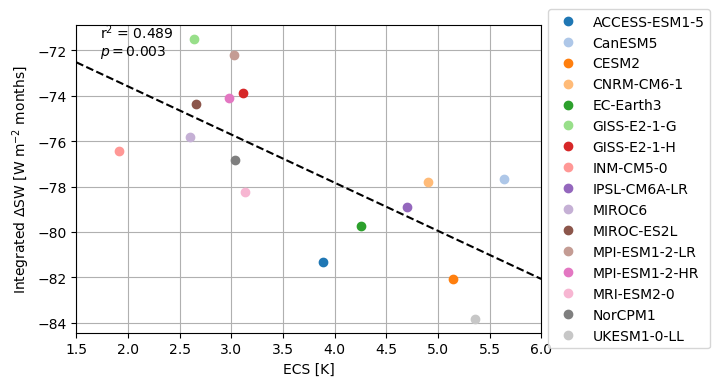

In [18]:
fig = plt.figure(1)

for n, name in enumerate(models):
    plt.plot(ecs_dict[name], SW_sum[name], 'o', color=colors[n], label=name)
    
sw_array = np.array([float(SW_sum[name].data) for name in models])

slope, intcpt, r_value, p_value, std_err = linregress(ecs_array, sw_array)

y = slope*x + intcpt

plt.plot(x, y, "k--")
plt.xlim(1.5, 6)

plt.annotate(f"r$^2$ = {r_value**2:5.3f}\n$p=${p_value:5.3f}",
             xy=(0.05, 0.9),
             xycoords="axes fraction")

plt.grid()
plt.ylabel("Integrated $\Delta$SW [W m$^{-2}$ months]")
plt.xlabel("ECS [K]")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

fig.savefig("../../../figures/volcano/2021/twolyr/twolyr_sw_corr.png",
            bbox_inches="tight", dpi=150)

out = {"slope": slope,
       "intcpt": intcpt,
       "r_value": r_value,
       "p_value": p_value,
       "std_err": std_err}

with open("integrate_sw_twolyr_result.pkl", "wb") as f:
    pkl.dump(out, f)